In [1]:
%cd /content/
!git --version
!git config --global user.email “thesirpotato514@gmail.com”
!git config --global user.name “louis zhu”

%cd APS360
!git pull origin main

/content
git version 2.34.1
Cloning into 'APS360'...
remote: Enumerating objects: 3146, done.
remote: Counting objects: 100% (1093/1093), done.
remote: Compressing objects: 100% (1070/1070), done.
remote: Total 3146 (delta 27), reused 1087 (delta 21), pack-reused 2053 (from 1)
Receiving objects: 100% (3146/3146), 110.83 MiB | 8.44 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Updating files: 100% (3058/3058), done.
/content/APS360
From https://github.com/zehuasong/APS360
 * branch            main       -> FETCH_HEAD
Already up to date.


###Segmentation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_segmentation(img, debug=False):
    # 2) Threshold & Invert (so brackets/digits become white on black)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3) (Optional) Morphological Opening to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 4) Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bracket_contours = []
    other_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        # Heuristic filters for bracket detection:
        # - Brackets might be tall and relatively thin (or short and wide)
        # - Adjust these thresholds to match your images
        aspect_ratio = w / float(h + 1e-5)  # avoid division by zero
        if area > 31000 and (0.1 < aspect_ratio < 0.4 or 2.5 < aspect_ratio < 10):
            # This is likely a bracket (depending on orientation).
            bracket_contours.append((cnt, x, y, w, h))
        else:
            # Might be digits or noise
            other_contours.append((cnt, x, y, w, h))

    # Sort bracket contours from left to right based on x
    bracket_contours.sort(key=lambda bc: bc[1])

    # For a 2×2 matrix side by side, you might expect 4 brackets total (2 for left matrix, 2 for right matrix).
    # bracket_contours = [ (cnt, x, y, w, h), ... ] sorted by x
    if debug: print(f"Found {len(bracket_contours)} potential bracket(s).")

    # Just for visualization: draw bracket bounding boxes on a copy of the image
    if debug:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i, (cnt, x, y, w, h) in enumerate(bracket_contours):
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img_color, f"B{i}", (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_color[:,:,::-1])  # BGR -> RGB
        plt.title("Detected Brackets (Bounding Boxes)")
        plt.axis('off')
        plt.show()

    ###############################
    # 5) USE BRACKETS TO SEPARATE #
    ###############################
    # Example approach:
    # - Suppose bracket_contours[0] is the left bracket of the first matrix
    # - bracket_contours[1] is the right bracket of the first matrix
    # - bracket_contours[2] is the left bracket of the second matrix
    # - bracket_contours[3] is the right bracket of the second matrix

    if len(bracket_contours) >= 4:
        # Extract bounding boxes for the two matrix regions:
        # We'll define each matrix region from the right edge of its left bracket
        # to the left edge of its right bracket
        _, x1, y1, w1, h1 = bracket_contours[0]  # left bracket (matrix 1)
        _, x2, y2, w2, h2 = bracket_contours[1]  # right bracket (matrix 1)

        matrix1_left = x1 + w1
        matrix1_right = x2
        matrix1_top = min(y1, y2)
        matrix1_bottom = max(y1 + h1, y2 + h2)

        # Crop out the first matrix
        matrix1 = thresh[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]
        matrix1_color = img[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]

        _, x3, y3, w3, h3 = bracket_contours[2]  # left bracket (matrix 2)
        _, x4, y4, w4, h4 = bracket_contours[3]  # right bracket (matrix 2)

        matrix2_left = x3 + w3
        matrix2_right = x4
        matrix2_top = min(y3, y4)
        matrix2_bottom = max(y3 + h3, y4 + h4)

        # Crop out the second matrix
        matrix2 = thresh[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]
        matrix2_color = img[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]

        # Crop out operator
        op = thresh[:, matrix1_right + w2:matrix2_left - w3]
        op_color = img[:, matrix1_right + w2:matrix2_left - w3]

        # Display the two cropped matrices
        if debug:
            fig, axs = plt.subplots(1, 2, figsize=(8,4))
            axs[0].imshow(matrix1, cmap='gray')
            axs[0].set_title("Matrix 1")
            axs[0].axis('off')

            axs[1].imshow(matrix2, cmap='gray')
            axs[1].set_title("Matrix 2")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()
    else:
        print("Not enough bracket contours found to confidently separate the matrices.")
    return matrix1, matrix2, matrix1_color, matrix2_color, op, op_color


In [ ]:
# Find external contours in the thresholded image
def find_objects(matrix, id, debug=False):
    contours, hierarchy = cv2.findContours(
        matrix.copy(),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    digit_contours = []
    for cnt in contours:
        if len(contours) == 1:
          digit_contours.append(cnt)
          break
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        # Filter out too-small or too-large regions
        if debug: print("curr area", area)
        if 7000 < area < 40000:  # adjust as needed
            digit_contours.append(cnt)

    if debug: print(f"Total digit candidates found for matrix {id}:", len(digit_contours))
    return digit_contours

In [ ]:
def group_contours_by_rows(digit_contours, matrix, id, y_threshold=15, debug=False):
    """
    digit_contours: list of (cnt, x, y, w, h)
    y_threshold: vertical tolerance to consider two bounding boxes in the same row

    Returns a list of rows, where each row is a list of (cnt, x, y, w, h).
    """
    # 1) Compute the center y for each bounding box
    boxes = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        center_y = y + h/2.0
        boxes.append((cnt, x, y, w, h, center_y))

    # 2) Sort by center_y
    boxes.sort(key=lambda b: b[5])

    # 3) Group into rows
    rows = []
    current_row = [boxes[0]]

    for i in range(1, len(boxes)):
        prev_center_y = current_row[-1][5]
        current_center_y = boxes[i][5]

        # If the next box's center_y is within y_threshold of the last box in current row,
        # consider it part of the same row
        if abs(current_center_y - prev_center_y) < y_threshold:
            current_row.append(boxes[i])
        else:
            # Start a new row
            rows.append(current_row)
            current_row = [boxes[i]]

    # Add the final row
    rows.append(current_row)

    # 4) Sort each row by x, and sort rows by the average center_y
    sorted_rows = []
    for row in rows:
        row_sorted = sorted(row, key=lambda b: b[1])  # sort by x
        sorted_rows.append(row_sorted)
    # Sort rows by average y-center of each row
    sorted_rows.sort(key=lambda r: np.mean([box[5] for box in r]))

    # 5) Return rows without the extra center_y in each tuple
    # Each row is now in left-to-right order, and rows are top-to-bottom
    final_rows = []
    for row in sorted_rows:
        final_rows.append([(cnt, x, y, w, h) for (cnt, x, y, w, h, c_y) in row])

    max_len = max(len(row) for row in final_rows)

    # 3) Loop through each row and each digit, display them in subplots.
    digits = []
    for row in final_rows:
        for cnt_info in row:
            _, x, y, w, h = cnt_info
            digit_crop = matrix[y:y+h, x:x+w]
            digits.append(digit_crop)

    if debug:
        # 2) Create subplots with one row per detected "row of digits".
        num_rows = len(final_rows)
        fig, axes = plt.subplots(num_rows, max_len, figsize=(3*max_len, 3*num_rows))

        # Ensure axes is a 2D array even when there's only one row or one column
        if num_rows == 1:
            axes = np.expand_dims(axes, 0)
        if max_len == 1:
            axes = np.expand_dims(axes, 1)

        for i, row in enumerate(final_rows):
            for j in range(max_len):
                ax = axes[i][j]
                if j < len(row):
                    _, x, y, w, h = row[j]
                    digit_crop = matrix[y:y+h, x:x+w]
                    ax.imshow(digit_crop, cmap='gray')
                    ax.set_title(f"Row {i}, Col {j}")
                ax.axis('off')

        plt.suptitle(f"Extracted Digits for matrix {id}", fontsize=16)
        plt.tight_layout()
        plt.show()

    return digits

def crop_and_display_op(operator_contours, op_color, debug=False):
    cropped_ops = []
    num_ops = len(operator_contours)

    # Loop over each contour, crop the image, and display it.
    for cnt in operator_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = op_color[y:y+h, x:x+w]
        cropped_ops.append(cropped)

    if debug:
        # Create a row of subplots for each cropped operator image
        fig, axes = plt.subplots(1, num_ops, figsize=(4*num_ops, 4))
        # If there's only one operator, axes is not a list, so we wrap it in a list.
        if num_ops == 1:
            axes = [axes]

        for idx, cropped in enumerate(cropped_ops):
            axes[idx].imshow(cropped, cmap='gray')
            axes[idx].set_title(f"Operator {idx}")
            axes[idx].axis('off')

        plt.suptitle(f"Matrix OP", fontsize=16)
        plt.tight_layout()
        plt.show()

    return cropped_ops

Run all segmentation process

Found 4 potential bracket(s).


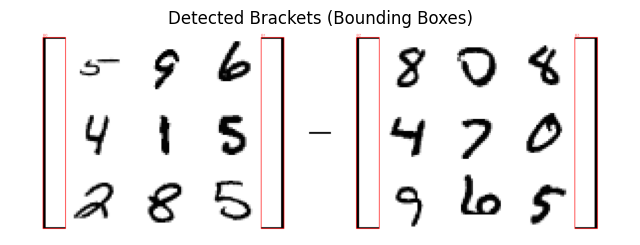

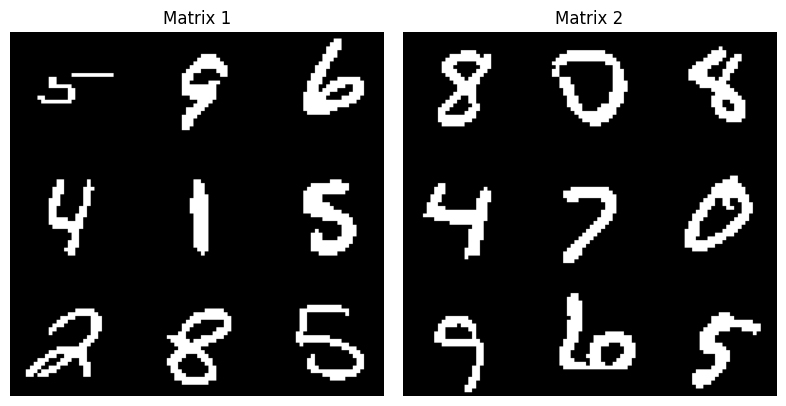

curr area 28365
curr area 30012
curr area 29848
curr area 23424
curr area 8235
curr area 20130
curr area 5824
curr area 909
curr area 20130
curr area 26718
Total digit candidates found for matrix 1: 8
curr area 21777
curr area 30195
curr area 33489
curr area 23424
curr area 30012
curr area 29848
curr area 33306
curr area 23424
curr area 24934
Total digit candidates found for matrix 2: 9
Total digit candidates found for matrix op: 1


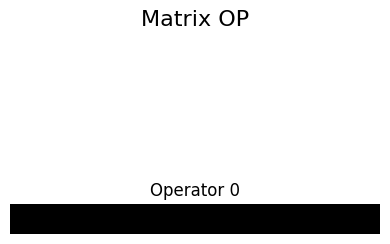

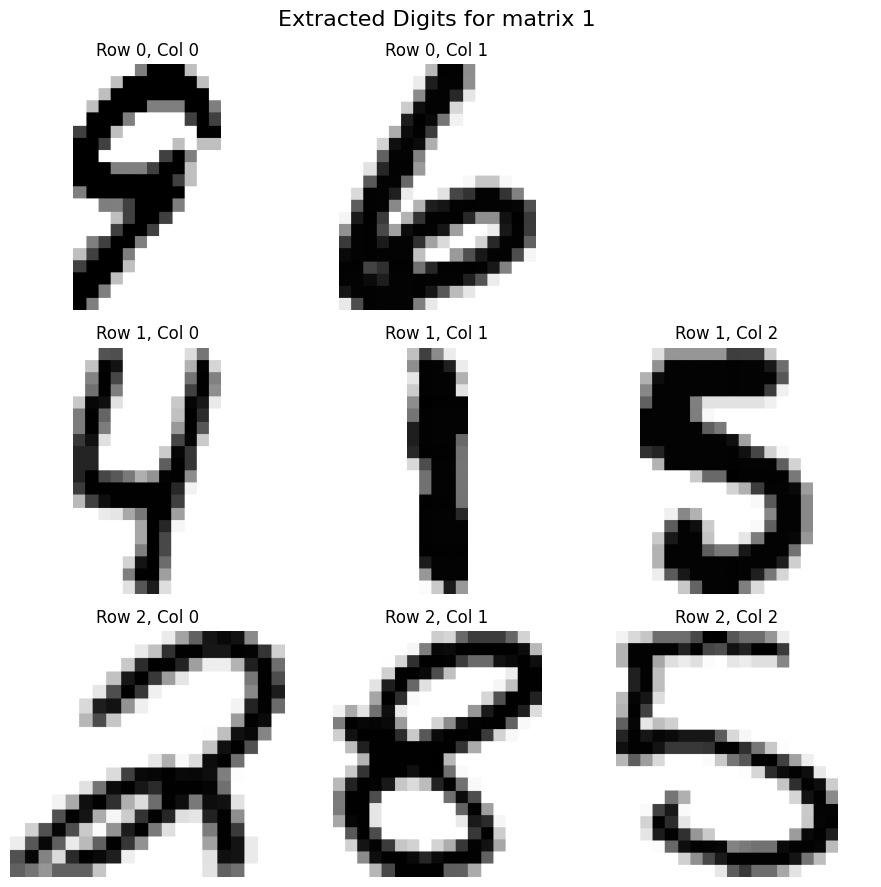

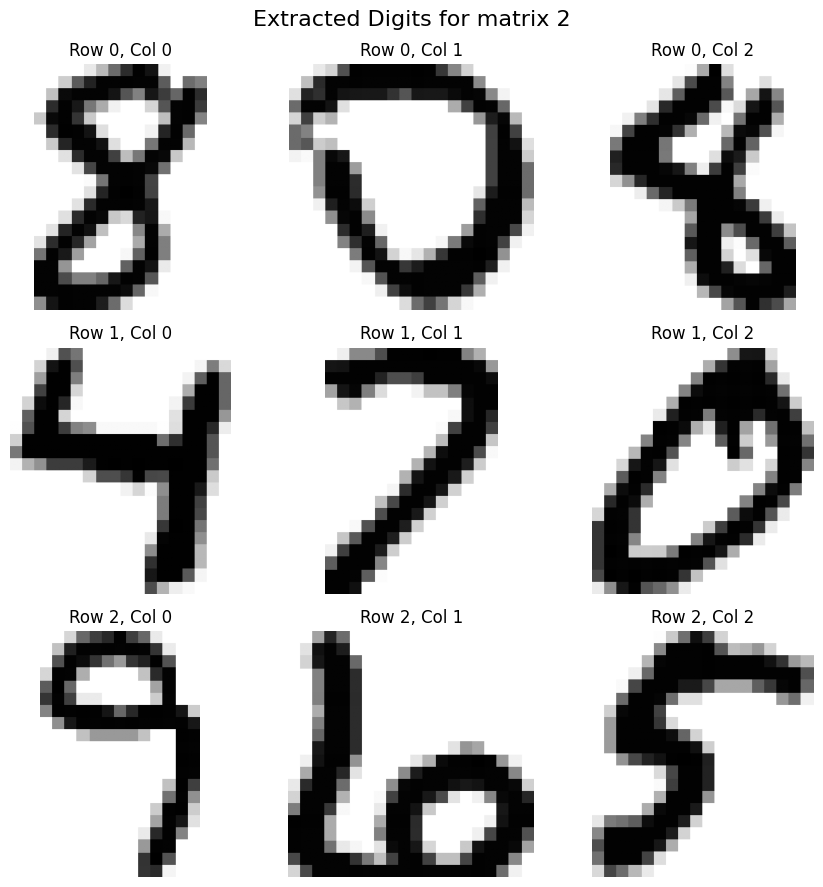

<Figure size 1000x500 with 0 Axes>

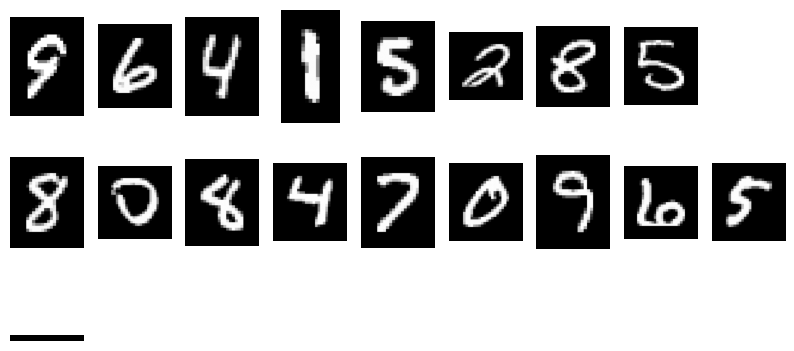

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import os
import shutil

def adaptive_pooling(image_list, output_size=(28, 28)):
    """
    Apply adaptive pooling to resize images to a fixed size.
    """
    processed_images = []
    for img in image_list:
        if img is None or not isinstance(img, np.ndarray) or img.size == 0:
            continue

        # # Convert to tensor
        # img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Ensure channel dimension

        # # Adaptive Pooling
        # pooled_img = F.adaptive_avg_pool2d(img_tensor.unsqueeze(0), output_size).squeeze(0)

        # # Convert back to numpy and remove extra dimension
        # pooled_img_np = pooled_img.numpy().astype(np.uint8).squeeze()

        # Convert to PIL Image
        pil_image = Image.fromarray(img)
        processed_images.append(pil_image)

    return processed_images

def flatten_list(nested_list):
    """Flatten a list of lists into a single list."""
    flat_list = []
    for sublist in nested_list:
        if isinstance(sublist, list):
            flat_list.extend(sublist)  # Add all elements if it's a list
        else:
            flat_list.append(sublist)  # Add element directly if it's not a list
    return flat_list

def matrix_segmentation(img, debug=False):
    matrix1, matrix2, matrix1_color, matrix2_color, op, op_color = image_segmentation(img, debug)
    digit_contours_1 = find_objects(matrix1, 1, debug)
    digit_contours_2 = find_objects(matrix2, 2, debug)
    operator_contours = find_objects(op, "op", debug)
    cropped_op = crop_and_display_op(operator_contours, op_color, debug)
    digits_1 = group_contours_by_rows(digit_contours_1, matrix1_color, 1, 150, debug)
    digits_2 = group_contours_by_rows(digit_contours_2, matrix2_color, 2, 150, debug)

    # Invert the images before pooling (White digits on black background)
    digits_1 = [cv2.bitwise_not(img) for img in flatten_list(digits_1)]
    digits_2 = [cv2.bitwise_not(img) for img in flatten_list(digits_2)]

    # Add black padding around each digit before pooling
    def add_black_padding(images, pad=50):
        return [cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0]) for img in images]

    digits_1 = add_black_padding(digits_1)
    digits_2 = add_black_padding(digits_2)

    # Apply Adaptive Pooling
    pooled_digits_1 = adaptive_pooling(digits_1)
    pooled_digits_2 = adaptive_pooling(digits_2)
    pooled_op = adaptive_pooling(cropped_op)  # Treat same as digits

    # Display results
    if debug:
        plt.figure(figsize=(10, 5))

        max_len = max(len(pooled_digits_1), len(pooled_digits_2), len(pooled_op))

        plt.figure(figsize=(10, 5))

        for i, img in enumerate(pooled_digits_1):
            plt.subplot(3, max_len, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        for i, img in enumerate(pooled_digits_2):
            plt.subplot(3, max_len, max_len + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        for i, img in enumerate(pooled_op):
            plt.subplot(3, max_len, 2 * max_len + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        plt.show()

    return pooled_digits_1, pooled_digits_2, pooled_op[0]

def save_processed_images(images, folder_name):
    """Save processed PIL images into a specified folder."""
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)  # Remove existing directory
    os.makedirs(folder_name, exist_ok=True)

    for i, img in enumerate(images):
        img_path = os.path.join(folder_name, f"image_{i}.png")
        img.save(img_path)

img = cv2.imread('MNIST_dataset_op/test/images/2x2_17.png', cv2.IMREAD_GRAYSCALE)
digits_1_2x2, digits_2_2x2, cropped_op_2x2 = matrix_segmentation(img, debug=False)

# save_processed_images(digits_1_2x2, "testing_processed_data/digits_1_2x2")
# save_processed_images(digits_2_2x2, "testing_processed_data/digits_2_2x2")
# save_processed_images([cropped_op_2x2], "testing_processed_data/cropped_op_2x2")

img = cv2.imread('MNIST_dataset_op/test/images/3x3_29.png', cv2.IMREAD_GRAYSCALE)
digits_1_3x3, digits_2_3x3, cropped_op_3x3 = matrix_segmentation(img, debug=True)

# save_processed_images(digits_1_3x3, "testing_processed_data/digits_1_3x3")
# save_processed_images(digits_2_3x3, "testing_processed_data/digits_2_3x3")
# save_processed_images([cropped_op_3x3], "testing_processed_data/cropped_op_3x3")

# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
class OperatorNet(nn.Module):
    def __init__(self, num_classes=3):
        super(OperatorNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms

operator_map = {
    0: "+",
    1: "-",
    2: "×"
}

# Transform for digit model (expects 1 channel)
digit_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale (1 channel)
    transforms.ToTensor()
])

# Transform for operator model (expects 3 channels)
operator_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for OperatorNet
    transforms.ToTensor()
])

def rec_operation(list1, list2, operator, digit_model, operator_model):
  digit_model.eval()
  operator_model.eval()
  recognized_digits_1 =[]
  for img in list1:
    x = digit_transform(img).unsqueeze(0)
    with torch.no_grad():
      logits = digit_model(x)
      pred = logits.argmax(dim=-1)
    recognized_digits_1.append(pred.item())
  recognized_digits_2 =[]
  for img in list2:
    x = digit_transform(img).unsqueeze(0)
    with torch.no_grad():
      logits = digit_model(x)
      pred = logits.argmax(dim=-1)
    recognized_digits_2.append(pred.item())
  op_x = operator_transform(operator).unsqueeze(0)
  with torch.no_grad():
    logits = operator_model(op_x)
    pred = logits.argmax(dim=-1)
  # print(f"Predicted operator index: {pred.item()}")  # Debugging output
  operator_pred = operator_map[pred.item()]
  return recognized_digits_1, recognized_digits_2, operator_pred

In [ ]:
# Initialize model architectures
digit_model = DigitNet()  # Replace with your actual model class
operator_model = OperatorNet()  # Replace with your actual model class

# Load the saved state dictionaries
digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
operator_model.load_state_dict(torch.load("checkpoint/model_OperatorNet_bs32_lr0.01_epoch9"))

digits1_2x2, digits2_2x2, op_2x2 = rec_operation(digits_1_2x2, digits_2_2x2, cropped_op_2x2, digit_model, operator_model)
digits1_3x3, digits2_3x3, op_3x3 = rec_operation(digits_1_3x3, digits_2_3x3, cropped_op_3x3, digit_model, operator_model)

Predicted operator index: 1
Predicted operator index: 0


<ipython-input-69-24a097e72961>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
<ip

In [ ]:
import numpy as np
def perform_operation(list1, list2, operator):
    dmatrix1=[int(d) for d in list1]
    dmatrix2=[int(d) for d in list2]
    if(len(dmatrix1) == 4) and (len(dmatrix2) == 4):
      size=2
    elif len(dmatrix1) == 9 and len(dmatrix2) == 9:
      size =3
    else:
      return None, None, None
    matrix1= np.array(dmatrix1).reshape(size,size)
    matrix2= np.array(dmatrix2).reshape(size,size)
    if operator == '+':
        result = matrix1 + matrix2
    elif operator == '-':
        result = matrix1 - matrix2
    elif operator == '×':
        result = np.matmul(matrix1, matrix2)
    else:
        return None, None, None

    return matrix1, matrix2, result

In [ ]:
m1, m2, res = perform_operation(digits1_2x2, digits2_2x2, op_2x2)
print("Matrix 1:\n", m1)
print("Matrix 2:\n", m2)
print("Op:\n", op_2x2)
print("Result:\n", res)
m1, m2, res = perform_operation(digits1_3x3, digits2_3x3, op_3x3)
print("Matrix 1:\n", m1)
print("Matrix 2:\n", m2)
print("Op:\n", op_3x3)
print("Result:\n", res)

Matrix 1:
 [[0 4]
 [3 7]]
Matrix 2:
 [[4 3]
 [2 8]]
Op:
 -
Result:
 [[-4  1]
 [ 1 -1]]
Matrix 1:
 [[3 6 6]
 [0 8 9]
 [0 0 0]]
Matrix 2:
 [[3 9 3]
 [1 7 6]
 [9 9 2]]
Op:
 +
Result:
 [[ 6 15  9]
 [ 1 15 15]
 [ 9  9  2]]


In [ ]:
import cv2
import torch
import numpy as np
import os

def evaluate_computation():
    image_dir = "MNIST_dataset_op/test/images/"
    label_file_2x2 = "MNIST_dataset_op/test/labels_2x2.npy"
    label_file_3x3 = "MNIST_dataset_op/test/labels_3x3.npy"

    # Load labels
    labels_2x2 = np.load(label_file_2x2)
    labels_3x3 = np.load(label_file_3x3)

    # Initialize model architectures
    digit_model = DigitNet()  # Replace with your actual model class
    operator_model = OperatorNet()  # Replace with your actual model class

    # Load the saved state dictionaries
    digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
    operator_model.load_state_dict(torch.load("checkpoint/model_OperatorNet_bs32_lr0.01_epoch9"))

    correct_2x2 = 0
    total_2x2 = 0
    correct_3x3 = 0
    total_3x3 = 0

    # Iterate over 2x2 images
    for i in range(len(labels_2x2)):
        image_path = os.path.join(image_dir, f"2x2_{i}.png")
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping missing image: {image_path}")
            continue

        # Segment the image
        digits_1_2x2, digits_2_2x2, cropped_op_2x2 = matrix_segmentation(img, debug=False)

        # Run the forward pass
        digits1_2x2, digits2_2x2, op_2x2 = rec_operation(digits_1_2x2, digits_2_2x2, cropped_op_2x2, digit_model, operator_model)

        # Compute result
        m1, m2, res = perform_operation(digits1_2x2, digits2_2x2, op_2x2)

        # Check if res is None (error case)
        if res is None:
            print(f"Error encountered in computation for {image_path}, skipping.")
            continue

        # Compare with ground truth
        if np.array_equal(res, labels_2x2[i]):
            correct_2x2 += 1
        total_2x2 += 1

    # Iterate over 3x3 images
    for i in range(len(labels_3x3)):
        image_path = os.path.join(image_dir, f"3x3_{i}.png")
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping missing image: {image_path}")
            continue

        # Segment the image
        digits_1_3x3, digits_2_3x3, cropped_op_3x3 = matrix_segmentation(img, debug=False)

        # Run the forward pass
        digits1_3x3, digits2_3x3, op_3x3 = rec_operation(digits_1_3x3, digits_2_3x3, cropped_op_3x3, digit_model, operator_model)

        # Compute result
        m1, m2, res = perform_operation(digits1_3x3, digits2_3x3, op_3x3)

        # Check if res is None (error case)
        if res is None:
            print(f"Error encountered in computation for {image_path}, skipping.")
            continue

        # Compare with ground truth
        if np.array_equal(res, labels_3x3[i]):
            correct_3x3 += 1
        total_3x3 += 1

    # Compute accuracy
    accuracy_2x2 = (correct_2x2 / total_2x2) * 100 if total_2x2 > 0 else 0
    accuracy_3x3 = (correct_3x3 / total_3x3) * 100 if total_3x3 > 0 else 0

    print(f"2x2 Matrix Computation Accuracy: {accuracy_2x2:.2f}%")
    print(f"3x3 Matrix Computation Accuracy: {accuracy_3x3:.2f}%")


evaluate_computation()

<ipython-input-84-4bdec804dfde>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
<i

Error encountered in computation for MNIST_dataset_op/test/images/2x2_1.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_4.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_13.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_22.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_24.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_25.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/2x2_30.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/3x3_3.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/3x3_5.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/3x3_6.png, skipping.
Error encountered in computation for MNIST_dataset_op/test/images/3x3_8.png, skipping.
Error encountered in computation for M